# CNN-LSTM

In [1]:
%matplotlib inline


from sklearn.decomposition import PCA
import keras
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, Flatten, concatenate, Input, LSTM, BatchNormalization
from keras.optimizers import Adam
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing

#Imports
import pandas as pd
import numpy as np
from keras import layers
from keras.utils import to_categorical


#Splitting data
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split




import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

##### 1) Loading Data

In [2]:
import os
files_train = []
for i in os.listdir("zigzag/train"):
    files_train.append(["zigzag/train/"+i, "zigzag"])
    
    
for i in os.listdir("speedbumppassing/train"):
    files_train.append(["speedbumppassing/train/"+i, "speedbump"])
    
for i in os.listdir("potholes/train"):
    files_train.append(["potholes/train/"+i, "pothole"])

In [3]:
import os
files_test = []
for i in os.listdir("zigzag/test"):
    files_test.append(["zigzag/test/"+i, "zigzag"])
    
    
for i in os.listdir("speedbumppassing/test"):
    files_test.append(["speedbumppassing/test/"+i, "speedbump"])
    
for i in os.listdir("potholes/test"):
    files_test.append(["potholes/test/"+i, "pothole"])

In [4]:
import pathlib
import csv

import numpy as np


def csv2numpy(file_name):
    """Read multidimensional signal from file"""
    # Read data from file.
    data = np.genfromtxt(file_name, delimiter=",", skip_header=1)
    # Return all columns but the first one (as it is the index).
    return data[:, 1:-1]



def get_crops(files, length, discard_start, discard_end, padding_mode=None):
        """Return list with crops from files."""
        crops = []
        # Iterate over data files.
        for file, class_ in files:
            # Read from file.
            signal = csv2numpy(file)
            # Crop start and end.
            signal = signal[discard_start:(signal.shape[0] - discard_end)]
            windows, remainder = divmod(signal.shape[0], length)
            if padding_mode and remainder != 0:
                # Apply padding with given padding mode.
                padding = length * (windows + 1) - signal.shape[0]
                signal = np.pad(signal, ((0, padding), (0, 0)), padding_mode)
            elif padding_mode is None:
                # Crop the end.
                signal = signal[:(length * windows)]
            # Obtain crops from <discard_start> to <discard-end>.
            for i in range(0, signal.shape[0], length):
                crop = signal[i:(i + length)]
                crops.append([crop, class_])

        return crops

In [5]:
crops_train = get_crops(files_train, 245, 50, 50)
crops_test = get_crops(files_test, 245, 50, 50)

In [6]:
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(["zigzag", "speedbump", "pothole"]);

In [7]:
X_train = []
y_train = []
for i in crops_train:
    X_train.append(i[0])
    y_train.append(i[1])

In [8]:
X_test = []
y_test = []
for i in crops_test:
    X_test.append(i[0])
    y_test.append(i[1])

In [9]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [10]:
y_train = to_categorical(label_encoder.transform(y_train))
y_test = to_categorical(label_encoder.transform(y_test))

In [11]:
X_train.shape

(16618, 245, 6)

##### 3) Model Architecture

In [12]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense
from tensorflow.keras.regularizers import l2

# Define the model with L2 regularization
model = Sequential()

# TimeDistributed(Conv1D()) layer with parameters and L2 regularization
model.add(TimeDistributed(Conv1D(filters=16, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)), input_shape=(245, 6, 1)))

# TimeDistributed(MaxPooling1D()) layer with parameters and padding
model.add(TimeDistributed(MaxPooling1D(pool_size=2, padding='same')))

# TimeDistributed(Conv1D()) layer with parameters and L2 regularization
model.add(TimeDistributed(Conv1D(filters=8, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01))))

# TimeDistributed(MaxPooling1D()) layer with parameters and padding
model.add(TimeDistributed(MaxPooling1D(pool_size=2, padding='same')))

# TimeDistributed(Conv1D()) layer with parameters and L2 regularization
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01))))

# TimeDistributed(MaxPooling1D()) layer with parameters and padding
model.add(TimeDistributed(MaxPooling1D(pool_size=2, padding='same')))

# TimeDistributed(Conv1D()) layer with parameters and L2 regularization
model.add(TimeDistributed(Conv1D(filters=8, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01))))

# TimeDistributed(MaxPooling1D()) layer with parameters and padding
model.add(TimeDistributed(MaxPooling1D(pool_size=2, padding='same')))

# TimeDistributed(Flatten()) layer
model.add(TimeDistributed(Flatten()))

# Define LSTM model with parameters and L2 regularization
model.add(LSTM(units=60, return_sequences=True, kernel_regularizer=l2(0.01)))

# Additional LSTM layer with L2 regularization
model.add(LSTM(units=70, return_sequences=True, kernel_regularizer=l2(0.01)))

# Flatten layer outside TimeDistributed
model.add(Flatten())

# Dense layer with parameters and L2 regularization
model.add(Dense(units=3, activation='softmax', kernel_regularizer=l2(0.01)))  # Adjust units to match the number of output classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
520/520 [==============================] - 139s 257ms/step - loss: 0.5637 - accuracy: 0.9163 - val_loss: 1.5636 - val_accuracy: 0.6903
Epoch 2/30
520/520 [==============================] - 140s 269ms/step - loss: 0.3614 - accuracy: 0.9170 - val_loss: 0.9517 - val_accuracy: 0.6891
Epoch 3/30
520/520 [==============================] - 135s 260ms/step - loss: 0.3503 - accuracy: 0.9170 - val_loss: 1.2422 - val_accuracy: 0.6903
Epoch 4/30
520/520 [==============================] - 151s 291ms/step - loss: 0.3369 - accuracy: 0.9177 - val_loss: 1.2411 - val_accuracy: 0.6830
Epoch 5/30
520/520 [==============================] - 165s 318ms/step - loss: 0.3315 - accuracy: 0.9173 - val_loss: 1.0911 - val_accuracy: 0.6854
Epoch 6/30
520/520 [==============================] - 180s 345ms/step - loss: 0.3222 - accuracy: 0.9171 - val_loss: 1.0959 - val_accuracy: 0.6879
Epoch 7/30
520/520 [==============================] - 161s 309ms/step - loss: 0.2814 - accuracy: 0.9270 - val_loss: 0.9029 -

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time

##### 4) Training the model

##### 5) Finding Training and Testing Accuracy

In [1]:
# Plot the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: name 'plt' is not defined

In [15]:
test_loss,test_acc=model.evaluate(X_test, y_test)
test_loss,test_acc

26/26 [==============================] - 2s 67ms/step - loss: 0.5967 - accuracy: 0.8348


(0.5966648459434509, 0.8347613215446472)

##### 6) Compute and plot the confusion matrix for the three classes

In [17]:
predictions=model.predict(X_test)
class_labels = ['pothole', 'speedbumppassing', 'zigzag']
predicted_class_labels = [class_labels[np.argmax(pred)] for pred in predictions]
actual_class_labels=[class_labels[np.argmax(actual)] for actual in y_test]
print(classification_report(actual_class_labels, predicted_class_labels))

26/26 [==============================] - 3s 65ms/step
                  precision    recall  f1-score   support

         pothole       0.95      0.95      0.95       127
speedbumppassing       0.44      0.21      0.29       126
          zigzag       0.85      0.95      0.90       564

        accuracy                           0.83       817
       macro avg       0.75      0.70      0.71       817
    weighted avg       0.80      0.83      0.81       817



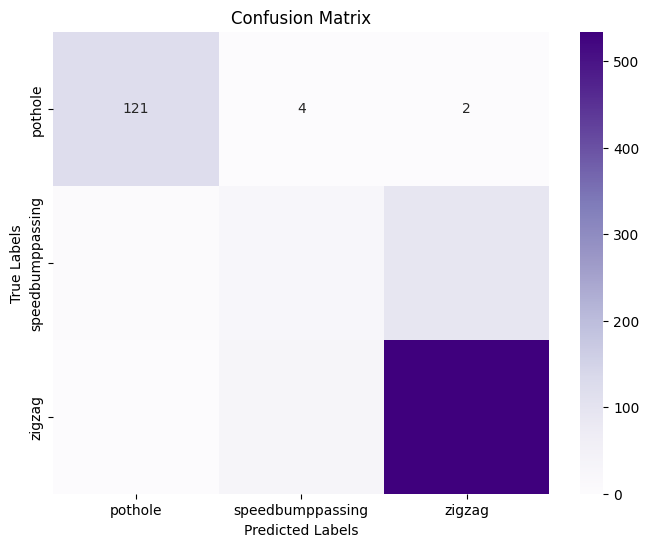

In [18]:
conf_matrix = confusion_matrix(actual_class_labels, predicted_class_labels, labels=class_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

##### 7) Saving the final results in Excel sheet

In [19]:
precision_per_class = precision_score(actual_class_labels, predicted_class_labels, average=None)
recall_per_class = recall_score(actual_class_labels, predicted_class_labels, average=None)

print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)

Precision per class: [0.95275591 0.44262295 0.84896661]
Recall per class: [0.95275591 0.21428571 0.94680851]


In [20]:
f1_micro = f1_score(actual_class_labels, predicted_class_labels, average='micro')
f1_macro = f1_score(actual_class_labels, predicted_class_labels, average='macro')

print("Micro F1 Score:", f1_micro)
print("Macro F1 Score:", f1_macro)

Micro F1 Score: 0.8347613219094248
Macro F1 Score: 0.7122493626913613


In [21]:
data={'SimpleCNN_Results':[max(history.history['accuracy']),test_acc,f1_micro,f1_macro,precision_per_class[0],precision_per_class[1],precision_per_class[2],recall_per_class[0],recall_per_class[1],recall_per_class[2]]}
result['SimpleCNN_Results']=pd.DataFrame(data,index=['Training Accuracy','Testing Accuracy','Micro F1 Score','Macro F1 Score','Precision for Negative sentiment','Precision for Positive sentiment','Precision for Neutral sentiment','Recall for Negative sentiment','Recall for Positive sentiment','Recall for Neutral sentiment'])
result['SimpleCNN_Results']

NameError: name 'history' is not defined

In [ ]:
result.to_csv('Results.csv', index=True)